# Project Title : Grading of Diabetic Retinopathy  

# **Import models**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
print(os.listdir("/content/drive/MyDrive/4"))

['DR_id.csv', 'dr_weights.hdf5', 'train', 'pread.csv', 'pre1.csv', 'test.csv', 'test1.csv', 'test2.csv', 'my_ml_lib.py', '__pycache__', 'cache', 'models']


In [ ]:
PATH = '/content/drive/MyDrive/4'
train = pd.read_csv(PATH + '/DR_id.csv')

In [ ]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


# To check how many images are in each category

In [ ]:
train['diagnosis'].value_counts().plot(kind = 'bar')

# Total Number of Images

In [ ]:
train['diagnosis'].value_counts().sort_index()[0]

In [ ]:
total = train['diagnosis'].value_counts().sum()
w0 = train['diagnosis'].value_counts().sort_index()[0] / total
w1 = train['diagnosis'].value_counts().sort_index()[1] / total
w2 = train['diagnosis'].value_counts().sort_index()[2] / total
w3 = train['diagnosis'].value_counts().sort_index()[3] / total
w4 = train['diagnosis'].value_counts().sort_index()[4] / total
class_wg = {0: w3, 1: w1, 2: w4, 3: w0, 4: w2}
#class_wg = {0: w0, 1: w1, 2: w2, 3: w3, 4: w4}

print('class weights:')
print('0: ', w0)
print('1: ', w1)
print('2: ', w2)
print('3: ', w3)
print('4: ', w4)

In [ ]:
print(train['diagnosis'].value_counts())

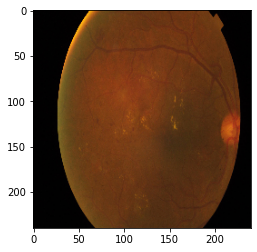

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

img = image.load_img(PATH + '/train/' + train['id_code'][0] + '.png', target_size = (240, 240, 3))
plt.imshow(img)


# Loading All Images

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
def load_images(df, dfPath):
    xdata = np.zeros((df.shape[0], 100, 100, 3))
    index = 0
    for id_code in df['id_code']:
        img = image.load_img(PATH + dfPath + '/' + id_code + '.png', target_size = (240, 240, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        xdata[index] = x
        index += 1
    xdata = xdata / 255.0
    return xdata       

In [ ]:
x_train = train.drop(['diagnosis'], axis = 1)
y_train = train['diagnosis']

In [ ]:
trainpath = '/train/'
x_train = load_images(train, trainpath)

In [ ]:
plt.imshow(x_train[0][:,:,:])

In [ ]:
plt.imshow(x_train[0])

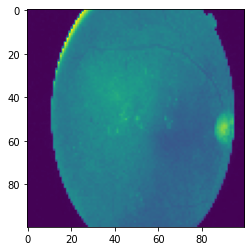

In [ ]:
plt.imshow(x_train[0][:,:,2])

In [ ]:
y_train.head()

0    2
1    4
2    1
3    0
4    0
Name: diagnosis, dtype: int64

In [ ]:
print(y_train.shape)

In [ ]:
del train

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 5)

In [ ]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

# Creating of CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(filters = 30, kernel_size = (5, 5), input_shape = (100, 100, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 15, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(filters = 15, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 15, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 15, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(128, activation = 'relu'))

model.add(Dense(64, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(5, activation = 'softmax'))


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 30)        2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 30)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 15)        4065      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 15)        2040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 15)        2

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=8
                             )
checkpointer = ModelCheckpoint(filepath="clf-CNN-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=3,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
import keras
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(x_train, y_train,validation_split = 0.2, epochs = 50, batch_size = 128, class_weight = class_wg,callbacks = [checkpointer, earlystopping])


Epoch 1/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0681 - accuracy: 0.4564 - val_loss: 0.4934 - val_accuracy: 0.5280

Epoch 00001: val_loss improved from inf to 0.49342, saving model to clf-CNN-weights.hdf5
Epoch 2/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0546 - accuracy: 0.3185 - val_loss: 0.4848 - val_accuracy: 0.0477

Epoch 00002: val_loss improved from 0.49342 to 0.48479, saving model to clf-CNN-weights.hdf5
Epoch 3/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0527 - accuracy: 0.3060 - val_loss: 0.4725 - val_accuracy: 0.5280

Epoch 00003: val_loss improved from 0.48479 to 0.47252, saving model to clf-CNN-weights.hdf5
Epoch 4/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0520 - accuracy: 0.4743 - val_loss: 0.4344 - val_accuracy: 0.4570

Epoch 00004: val_loss improved from 0.47252 to 0.43436, saving model to clf-CNN-weights.hdf5
Epoch 5/50
23/23 [==============================] - 1s 26ms/step

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


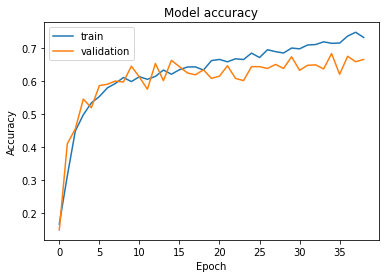

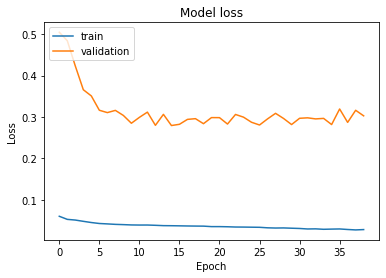

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


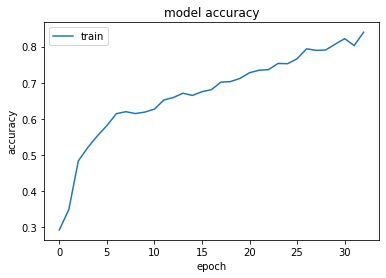

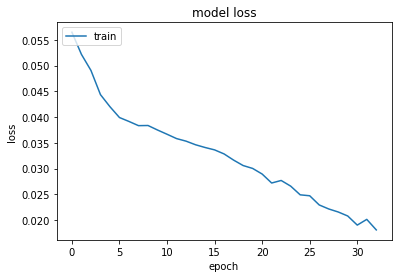

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


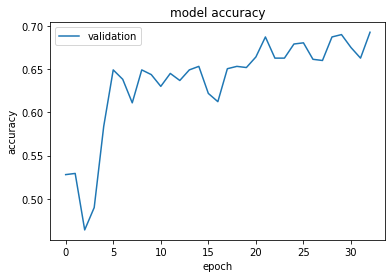

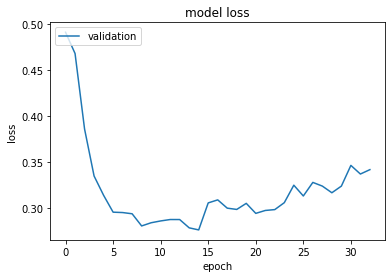

In [ ]:
print(history.history.keys())
#  "Accuracy"

plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'validation'], loc='upper left')
plt.show()
# "Loss"

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([ 'validation'], loc='upper left')
plt.show()

# Testing

In [ ]:
del x_train, y_train

In [ ]:
testPath = '/train/'
test = pd.read_csv(PATH + '/1.csv')
test=test.drop(['diagnosis'], axis=1)

In [ ]:
test.head()

,id_code
0,000c1434d8d7
1,001639a390f0
2,0024cdab0c1e
3,002c21358ce6
4,005b95c28852


In [ ]:
x_test = load_images(test,testPath)

In [ ]:
predictions = model.predict(x_test, verbose = 1)


18/18 [==============================] - 0s 3ms/step


In [ ]:
print(predictions)


In [ ]:
for i in range(len(test)):
    test.loc[i, 'diagnosis'] = np.argmax(predictions[i - 1])
test['diagnosis'] = test['diagnosis'].astype('int')

In [ ]:
test.head(11)

,id_code,diagnosis
0,000c1434d8d7,0
1,001639a390f0,2
2,0024cdab0c1e,2
3,002c21358ce6,1
4,005b95c28852,0
5,0083ee8054ee,0
6,0097f532ac9f,4
7,00a8624548a9,0
8,00b74780d31d,2
9,00cb6555d108,2


In [ ]:
test.to_csv('prediction_m.csv', index = False)

In [ ]:
y_pred=model.predict_classes(x_test, verbose = 1)
for i in y_pred:
    print(i)

18/18 [==============================] - 0s 4ms/step
2
2
1
0
0
4
0
2
2
1
0
2
0
3
2
0
2
0
0
2
4
0
1
2
0
3
0
0
0
0
0
0
3
0
4
2
0
0
4
0
4
2
2
4
4
1
2
4
0
3
2
2
2
3
2
0
1
0
3
1
0
2
0
0
0
0
3
2
0
0
0
3
3
2
3
0
3
0
2
0
3
3
3
0
2
0
3
4
2
2
0
0
0
0
3
0
3
3
0
3
2
0
0
0
4
4
0
0
4
4
2
0
0
2
0
0
0
0
0
3
0
3
4
0
0
4
0
0
0
0
2
0
3
3
2
1
0
0
1
0
0
0
2
0
3
3
4
0
2
4
2
0
0
0
0
0
1
4
2
0
0
3
2
2
3
2
0
3
0
0
0
0
3
0
2
0
1
0
0
0
2
0
0
0
0
1
0
1
3
1
0
4
0
0
2
4
0
4
0
3
0
4
1
0
3
0
3
3
1
3
0
2
3
3
0
3
0
0
2
1
0
2
2
0
0
0
4
2
0
2
0
4
3
3
2
2
3
3
2
0
2
0
3
0
3
3
0
2
0
0
3
3
2
0
2
0
2
3
0
0
0
2
0
2
3
3
2
0
4
4
2
0
3
2
0
0
0
0
2
0
0
2
2
0
3
0
1
2
0
3
3
0
0
0
0
2
2
0
3
3
0
0
2
3
3
2
3
0
1
0
0
0
0
0
3
3
0
3
3
4
0
0
0
0
4
0
3
0
0
2
2
0
0
0
0
2
2
0
3
0
3
0
3
1
0
2
3
1
0
0
1
4
3
0
0
3
0
2
4
4
2
0
2
0
2
0
4
0
0
2
3
0
0
2
1
2
4
3
2
0
1
0
1
4
3
2
2
2
0
3
1
0
0
0
0
0
2
0
0
1
2
0
0
0
0
0
2
4
0
4
0
0
2
0
2
4
0
0
0
3
2
0
0
4
3
2
2
0
0
3
0
3
0
2
0
0
4
2
3
0
0
0
3
0
2
0
2
0
0
0
4
0
2
3
3
0
0
1
2
3
2
0
3
3
0
0
0
4
4
0
2
0
2
4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred = pd.read_csv('/content/drive/MyDrive/4/pread.csv')


In [ ]:
testPath = '/train/'
test1 = pd.read_csv(PATH + '/pread.csv')
test1.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,1
2,0024cdab0c1e,1
3,002c21358ce6,1
4,005b95c28852,1


# Confusion matrix 

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=test1['diagnosis'][0:1490], y_pred=pred['diagnosis'])

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[132   9   8   2   4]
 [ 25  52  16   5   7]
 [ 13   3  86   2   3]
 [ 21   9  12  41   6]
 [ 19   7  13   4  46]]


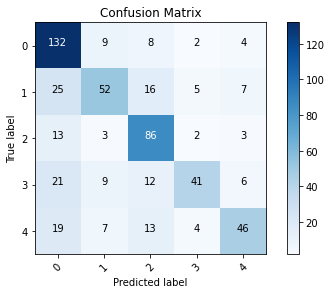

In [ ]:
cm_plot_labels = ['0', '1', '2', '3', '4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=test1['diagnosis'][0:1490], y_pred=pred['diagnosis'])


In [ ]:
y_true=test1['diagnosis'][0:1490]
y_pred=pred['diagnosis']

In [ ]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_true, y_pred, average=None, zero_division=1)